<a href="https://colab.research.google.com/github/pockypoem/orbit-ai/blob/main/Prediksi_Saham_TLKM_dengan_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Description

Ini adalah program yang menggunakan konsep Deep Learning yaitu Artificial Neural Network yang bernama LSTM (Long Short Term Memory) untuk melakukan prediksi harga saham dari sebuah perusahaan bernama Telkomsel (TLKM JK)

In [32]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Import Library**

In [89]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import yfinance as yf
from datetime import datetime
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [34]:
df = pd.read_excel("TLKM.JK.xlsx")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,3980.0,3980.0,3980.0,3980.0,3310.131592,0.0
1,2017-01-03,3950.0,3990.0,3920.0,3950.0,3285.180664,71660600.0
2,2017-01-04,3880.0,3980.0,3880.0,3950.0,3285.180664,68494500.0
3,2017-01-05,3960.0,4030.0,3940.0,3950.0,3285.180664,74018400.0
4,2017-01-06,3970.0,4010.0,3960.0,4000.0,3326.765381,44136900.0


## Exploratory Data

In [35]:
print(df.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [36]:
print(df['Close'])

0       3980.0
1       3950.0
2       3950.0
3       3950.0
4       4000.0
         ...  
1417    4490.0
1418    4520.0
1419    4480.0
1420    4560.0
1421    4580.0
Name: Close, Length: 1422, dtype: float64


<Axes: xlabel='Close', ylabel='Density'>

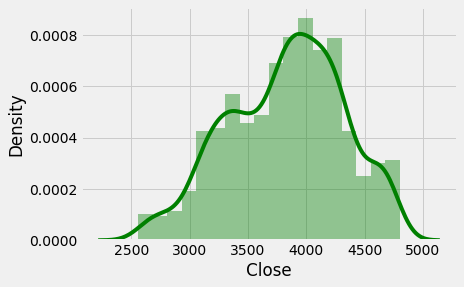

In [39]:
sns.distplot(df.Close, color="green")

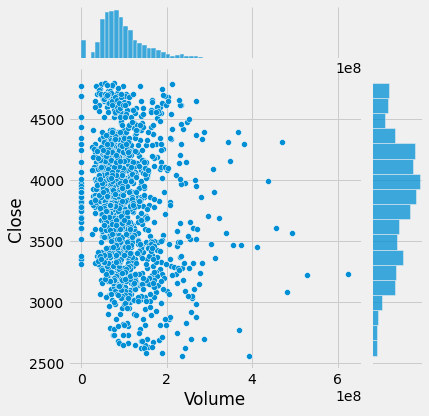

In [40]:
sns.jointplot(data=df, x="Volume", y="Close")

## Pre Processing Data

In [41]:
df.isnull().sum()/len(df)

Date         0.000000
Open         0.000703
High         0.000703
Low          0.000703
Close        0.000703
Adj Close    0.000703
Volume       0.000703
dtype: float64

In [42]:
mean_Open = df['Open'].mean()
mean_High = df['High'].mean()
mean_Low = df['Low'].mean()
mean_Close = df['Close'].mean()
mean_AdjClose = df['Adj Close'].mean()
mean_Volume = df['Volume'].mean()

In [43]:
df['Open'].fillna(mean_Open, inplace=True)
df['High'].fillna(mean_High, inplace=True)
df['Low'].fillna(mean_Low, inplace=True)
df['Close'].fillna(mean_Close, inplace=True)
df['Adj Close'].fillna(mean_AdjClose, inplace=True)
df['Volume'].fillna(mean_Volume, inplace=True)

In [44]:
#Mengubah tanggal menjadi index
con = df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#check datatype of index
df.index

DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13',
               ...
               '2022-08-19', '2022-08-22', '2022-08-23', '2022-08-24',
               '2022-08-25', '2022-08-26', '2022-08-29', '2022-08-30',
               '2022-08-31', '2022-09-01'],
              dtype='datetime64[ns]', name='Date', length=1422, freq=None)

In [45]:
df.shape

(1422, 6)

In [46]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,3980.0,3980.0,3980.0,3980.0,3310.131592,0.0
2017-01-03,3950.0,3990.0,3920.0,3950.0,3285.180664,71660600.0
2017-01-04,3880.0,3980.0,3880.0,3950.0,3285.180664,68494500.0
2017-01-05,3960.0,4030.0,3940.0,3950.0,3285.180664,74018400.0
2017-01-06,3970.0,4010.0,3960.0,4000.0,3326.765381,44136900.0


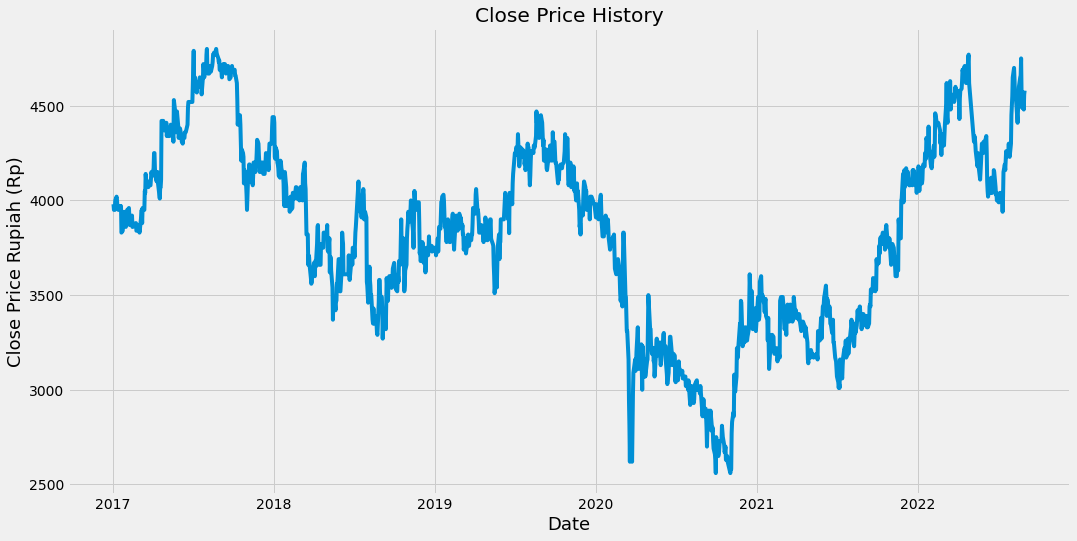

In [11]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.show()

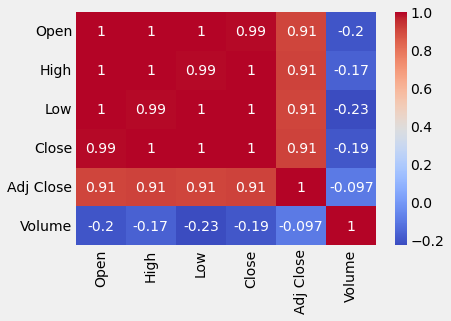

In [47]:
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(), cmap='coolwarm', annot=True)
plt.show()

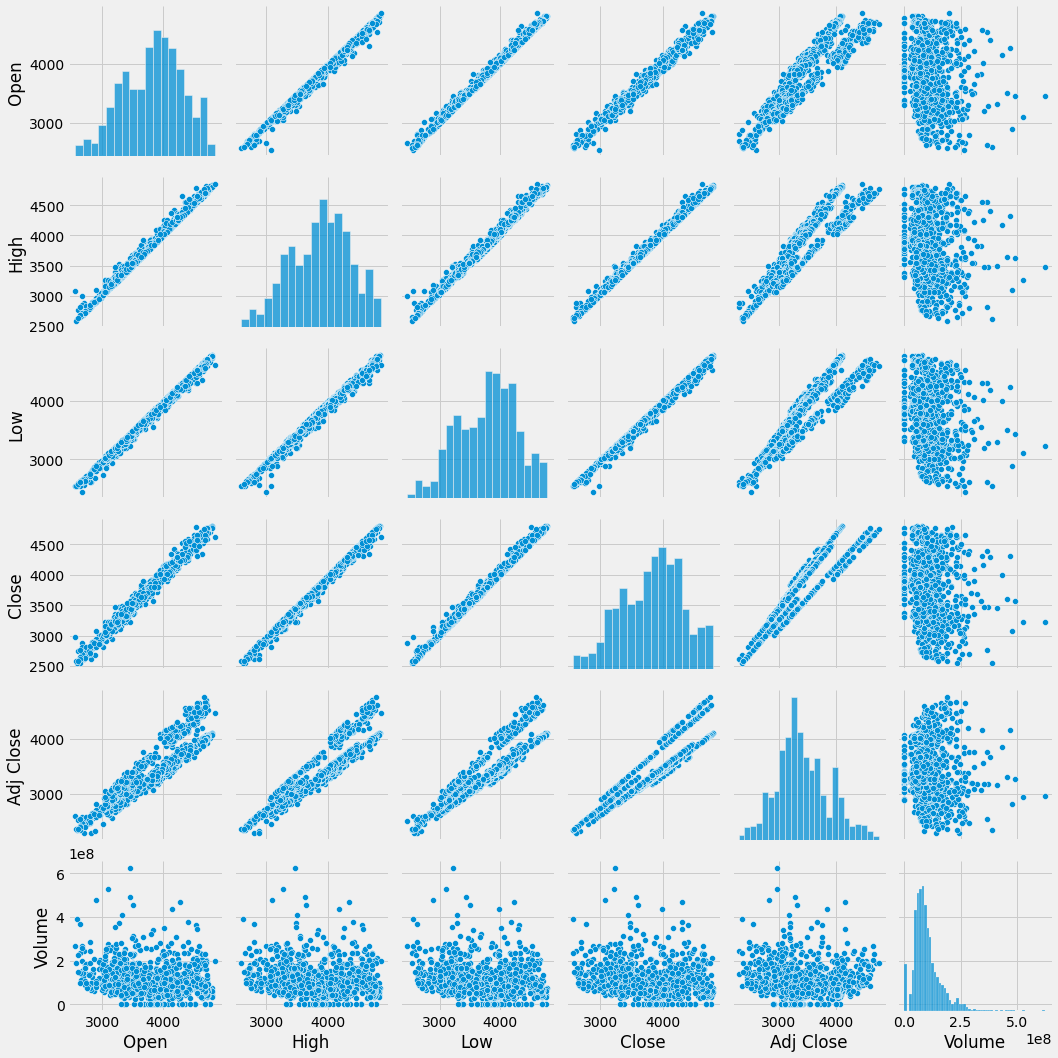

In [48]:
sns.pairplot(df)

## Train Test Split

In [50]:
# Create a new dataframe with only the 'Close Column'
data = df.filter(['Close'])

#Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on 
training_data_len = math.ceil(len(dataset) * .8) #round up

training_data_len

1138

In [51]:
dataset

array([[3980.],
       [3950.],
       [3950.],
       ...,
       [4480.],
       [4560.],
       [4580.]])

**Normalisasi Data**

In [52]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.63392857],
       [0.62053571],
       [0.62053571],
       ...,
       [0.85714286],
       [0.89285714],
       [0.90178571]])

**Membuat Dataset Training**

In [53]:
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

#split the data into x_train and y_train dataset
x_train = []
y_train = []

for i in range(100, len(train_data)):
  x_train.append(train_data[i-100:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 101:
    print(x_train)
    print(y_train)
    print()

[array([0.63392857, 0.62053571, 0.62053571, 0.62053571, 0.64285714,
       0.65178571, 0.64285714, 0.625     , 0.625     , 0.62053571,
       0.62053571, 0.62946429, 0.625     , 0.62946429, 0.56696429,
       0.57142857, 0.60267857, 0.59821429, 0.61607143, 0.59375   ,
       0.58035714, 0.58482143, 0.61607143, 0.62053571, 0.62053571,
       0.625     , 0.60714286, 0.58482143, 0.58482143, 0.59375   ,
       0.60714286, 0.58035714, 0.58035714, 0.58482143, 0.58482143,
       0.58482143, 0.58928571, 0.58928571, 0.57142857, 0.57142857,
       0.58482143, 0.57589286, 0.57589286, 0.56696429, 0.57589286,
       0.60714286, 0.62053571, 0.58928571, 0.625     , 0.62053571,
       0.62053571, 0.66517857, 0.66071429, 0.70535714, 0.69196429,
       0.6875    , 0.68303571, 0.67410714, 0.68303571, 0.67857143,
       0.67857143, 0.70982143, 0.70535714, 0.70089286, 0.71875   ,
       0.75446429, 0.75446429, 0.71875   , 0.70089286, 0.6875    ,
       0.70982143, 0.70982143, 0.68303571, 0.64732143, 0.6741

In [54]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

LSTM network expects the input to be three-dimensional in the form of number of samples number of time steps and number of features and now our x_train dataset is 2 dimensional

In [55]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1038, 100, 1)

## Build the LSTM Model

In [56]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False)) # False karena ga akan pake lstm layer

model.add(Dense(25))
model.add(Dense(1))

**Compile Model**

In [103]:
model.compile(optimizer='adam', loss='mean_squared_error')

**Train the Model**

In [104]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1038/1038 [==============================] - 57s 52ms/step - loss: 0.0015


**Membuat Dataset Testing**

In [105]:
# Create a new array containig scaled values form index 1542 to 2002
test_data = scaled_data[training_data_len - 100:, :]

# Create the dataset x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(100, len(test_data)):
  x_test.append(test_data[i-100:i, 0])

In [106]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [107]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [108]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # unscaling the values

9/9 [==============================] - 1s 29ms/step


In [109]:
predictions

array([[3072.0532],
       [3041.4207],
       [3051.7727],
       [3029.464 ],
       [3150.9443],
       [3121.0037],
       [3085.0996],
       [3079.6514],
       [3133.2183],
       [3162.0786],
       [3207.065 ],
       [3202.7722],
       [3251.8518],
       [3178.23  ],
       [3203.2688],
       [3263.0261],
       [3193.9502],
       [3236.4355],
       [3238.5234],
       [3299.5305],
       [3315.215 ],
       [3356.426 ],
       [3334.792 ],
       [3326.7178],
       [3269.0764],
       [3253.7957],
       [3348.0273],
       [3295.5208],
       [3341.3884],
       [3405.4934],
       [3380.7327],
       [3401.3608],
       [3435.9512],
       [3402.295 ],
       [3384.5613],
       [3375.4387],
       [3338.7646],
       [3406.3308],
       [3396.3757],
       [3352.1912],
       [3382.6047],
       [3393.289 ],
       [3394.1455],
       [3387.9636],
       [3347.2576],
       [3400.5315],
       [3341.0583],
       [3365.6409],
       [3435.928 ],
       [3439.886 ],


## Evaluation and Plot Data

In [110]:
# Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

67.75671249788935

## Plot the Data and Evaluation

In [111]:
data

,Close
Date,
2017-01-02,3980.0
2017-01-03,3950.0
2017-01-04,3950.0
2017-01-05,3950.0
2017-01-06,4000.0
...,...
2022-08-26,4490.0
2022-08-29,4520.0
2022-08-30,4480.0


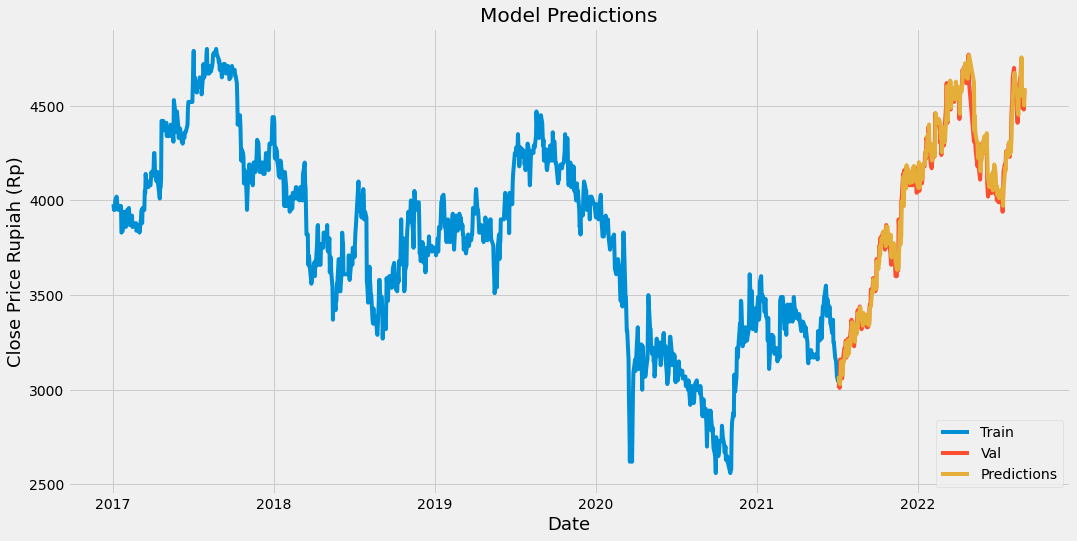

In [112]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the model
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [113]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2021-07-06,3010.0,3072.053223
2021-07-07,3030.0,3041.420654
2021-07-08,3010.0,3051.772705
2021-07-09,3160.0,3029.464111
2021-07-12,3130.0,3150.944336
...,...,...
2022-08-26,4490.0,4553.254883
2022-08-29,4520.0,4550.666016
2022-08-30,4480.0,4561.382324


In [114]:
# Get the quote
tlkm_quote = yf.download('TLKM.JK', start='2019-01-01', end='2022-12-22')

# Create a new dataframe
new_df = tlkm_quote.filter(['Close'])

# Get the last 100 day closing price values and convert the dataframe to an array
last_100_days = new_df[-100:].values
# Scale the data to be values between 0 and 1
last_100_days_scaled = scaler.transform(last_100_days)
# Create an empty list
X_test = []
# Append the past 100 days to x_test
X_test.append(last_100_days_scaled)
# Convert the X_test dataset to a numpy array
X_test = np.array(X_test)
# Reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 33ms/step
[[3801.741]]


In [115]:
tlkm_quote2 = yf.download('TLKM.JK', start='2022-12-23', end='2022-12-24')
print(tlkm_quote2['Close'])

[*********************100%***********************]  1 of 1 completed
Date
2022-12-23    3780.0
Name: Close, dtype: float64


## Kesimpulan

* Dalam memprediksi harga saham dapat menggunakan variabel **date** dan **close** karena merupakan variabel yang relevan.
* Arsitektur LSTM dapat digunakan untuk memprediksi harga saham PT Telkomsel (TLKM) dengan tingkat kesalahan error yang diukur menggunakan metrik evaluasi RMSE sebesar **67.756712**
* Model hasil LSTM memprediksi harga saham TLKM pada tanggal 23 Desember 2022 sebesar Rp 3,708 per lembar saham sedangkan harga asli dari saham TLKM pada tanggal tersebut sebesar **Rp 3,801** per lembar saham.